# HAR CNN training 

In [1]:
# Imports
import numpy as np
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
X, labels,  = read_data(data_path="./data/", split="train") # train
X_train,X_test, labels_train, labels_test = train_test_split(X, labels, test_size = 0.2, random_state = 0)  


In [3]:
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [17]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)
print(len(y_tr))

491


In [18]:
# Imports
import tensorflow as tf

### Hyperparameters

In [19]:
batch_size = 491     # Batch size
seq_len = 3000         # Number of steps
learning_rate = 0.001
epochs = 1000

n_classes = 5
n_channels = 1

### Construct the graph
Placeholders

In [39]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

Note: Should we use a different activation? Like tf.nn.tanh?

In [40]:
with graph.as_default():
    # (batch, 3000, 1) --> (batch, 750, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=4, strides=4, padding='same')
    
    # (batch, 750, 18) --> (batch, 150, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=5, strides=5, padding='same')
    
    # (batch, 150, 36) --> (batch, 30, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=5, strides=5, padding='same')

ValueError: Input 0 of layer conv1d_1 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 3000]

Now, flatten and pass to the classifier

In [36]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_3, (-1, 30*72))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [37]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [38]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

[[ -9.10845652e-02  -2.87169617e-01   4.58033302e-01 ...,   5.87989830e-01
    1.15857617e-02   5.51834380e-02]
 [ -3.49017178e-01   3.91295475e-01   5.66364270e-01 ...,   5.03089840e-01
    1.50668492e-02   4.76308629e-02]
 [  4.68691505e-01  -3.84029999e-01   1.81803046e-01 ...,   1.33021901e-01
    5.18449402e-01   3.63036844e-02]
 ..., 
 [ -1.77172331e-01   6.99624943e-02   5.63614611e-01 ...,   1.39160938e-01
    2.73298572e-01   4.38361862e-02]
 [ -4.89096639e-01  -4.55248642e-01   5.66831206e-02 ...,  -1.98073120e-01
    3.61420127e-01   4.04434332e-04]
 [  5.59122581e-02   1.41970488e-01   4.93426493e-01 ...,   4.09100196e-01
   -2.53111689e-01   4.31533802e-02]]
[[ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 ..., 
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]]


ValueError: Cannot feed value of shape (491, 3000) for Tensor 'inputs:0', which has shape '(?, 3000, 0)'

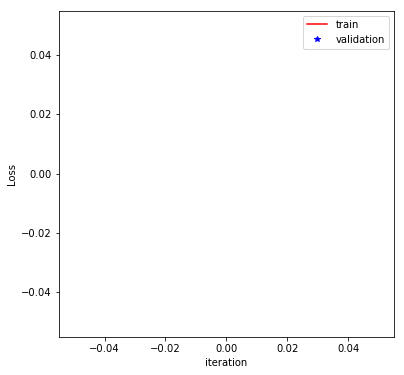

In [13]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

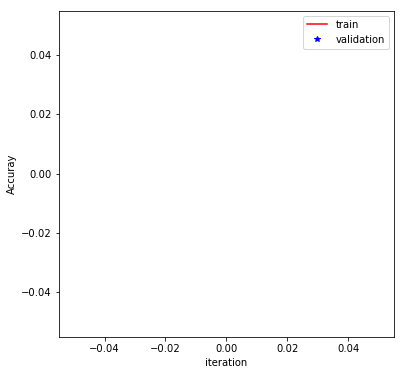

In [14]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [15]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: nan


/Users/zl-mac/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zl-mac/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
